In [1]:
import numpy as np

In [2]:
data_dict = np.load('russian punch cards/processed_arrays.npy')

In [3]:
data_list = list(data_dict[()].values())

In [4]:
data_unfolded = [np.ravel(d,order='C').astype(np.uint8) for d in data_list if d.shape[1]==24]

In [183]:
sum([np.mean(d) for d in data_list])/len(data_list)

0.58386218887762731

In [5]:
l = [d.shape[0] for d in data_unfolded]

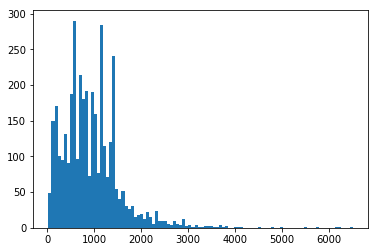

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
_ = plt.hist(l,bins=100)

In [7]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 1500

pad = pad_sequences(data_unfolded, maxlen=MAX_LEN, dtype=np.uint8, value=2,
                   padding='post', truncating='post')

Using TensorFlow backend.


In [8]:
from keras.utils import to_categorical
pad_c = np.array([to_categorical(seq,num_classes=3) for seq in pad])

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pad[:,:-1],pad[:,1:],test_size = 0.2)

In [10]:
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM, TimeDistributed



# inp = Input((None,3))
# x = BatchNormalization()(inp)
# x = Dropout(.5)(x)
# rnn = LSTM(128, activation='relu')(x)
# output = Dense(1, activation='softmax')(rnn)

model = Sequential([
    LSTM(128, activation='tanh', dropout=0.5, input_shape=(None,3), return_sequences=True),
    TimeDistributed(Dense(3, activation='softmax'))
])

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
X = pad_c[:,:-1,:]
y = pad_c[:,1:,:]

h = model.fit(x=X,y=y,batch_size=32,epochs=10,validation_split=0.2)

Train on 3000 samples, validate on 751 samples
Epoch 1/10
3000/3000 [==============================] - 337s - loss: 0.6117 - acc: 0.7095 - val_loss: 0.4233 - val_acc: 0.7849
Epoch 2/10
3000/3000 [==============================] - 345s - loss: 0.4850 - acc: 0.7431 - val_loss: 0.3819 - val_acc: 0.7959
Epoch 3/10
3000/3000 [==============================] - 368s - loss: 0.4234 - acc: 0.7706 - val_loss: 0.3733 - val_acc: 0.7964
Epoch 4/10
3000/3000 [==============================] - 338s - loss: 0.4031 - acc: 0.7826 - val_loss: 0.3689 - val_acc: 0.8009
Epoch 5/10
3000/3000 [==============================] - 340s - loss: 0.4138 - acc: 0.7820 - val_loss: 0.3813 - val_acc: 0.7848
Epoch 6/10
3000/3000 [==============================] - 338s - loss: 0.4041 - acc: 0.7863 - val_loss: 0.3667 - val_acc: 0.7972
Epoch 7/10
3000/3000 [==============================] - 337s - loss: 0.4127 - acc: 0.7813 - val_loss: 0.3775 - val_acc: 0.8028
Epoch 8/10
3000/3000 [==============================] - 325s - l

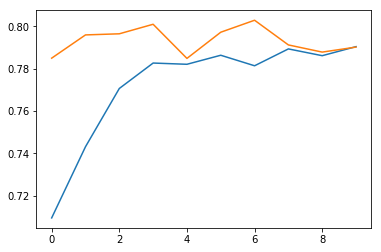

In [74]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])

In [39]:
np.argmax(model.predict(X[[0],:48,:]),axis=2)

(1, 48)

In [36]:
np.argmax(X[[0],:48,:],axis=2)

array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1]])

In [44]:
from PIL import Image

def plot_pattern(arr):
    arr = np.argmax(arr,axis=1)
    img = np.reshape(arr,(-1,24))
    return Image.fromarray(img.astype(np.uint8)*255).resize((img.shape[1]*13,img.shape[0]*13))

In [146]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array (from Keras library)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature  # Taking the log should be optional? add fudge factor to avoid log(0)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [161]:
def gen_predictions(seed, max_len, temp):
    output = seed
    for i in range(max_len-seed.shape[1]):
        pred = model.predict(output)
        next_stitch_idx = sample(np.squeeze(pred[:,-1,:]),temp)
        next_stitch = np.zeros(3)
        next_stitch[next_stitch_idx] = 1.0
        output = np.append(output,next_stitch[None,None,:],axis=1)
    return output

In [170]:
seed = pad_c[None,np.random.randint(pad_c.shape[0]),:96,:]

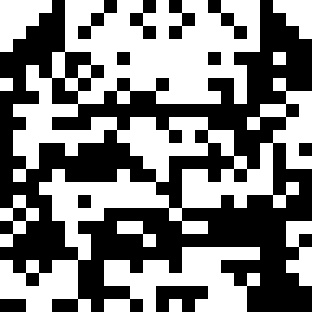

In [178]:
p = gen_predictions(seed,576,temp=0.8)
plot_pattern(np.squeeze(p))

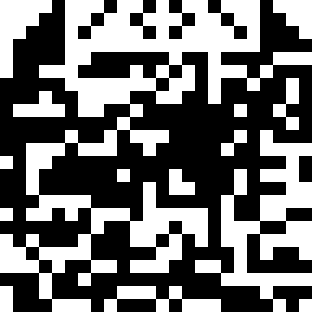

In [174]:
p = gen_predictions(seed,576,temp=0.5)
plot_pattern(np.squeeze(p))

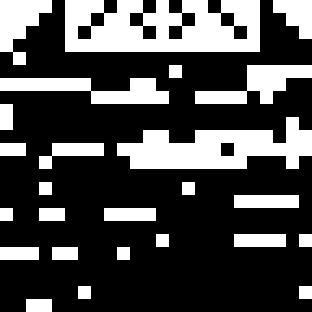

In [175]:
p = gen_predictions(seed,576,temp=0.2)
plot_pattern(np.squeeze(p))

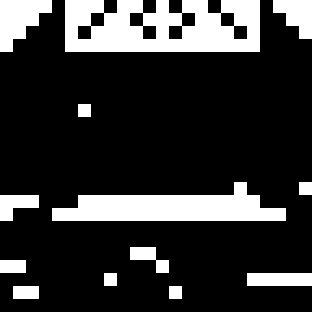

In [177]:
p = gen_predictions(seed,576,temp=0.15)
plot_pattern(np.squeeze(p))

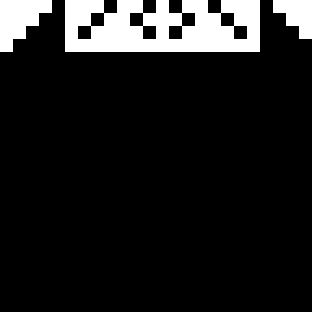

In [176]:
p = gen_predictions(seed,576,temp=0.1)
plot_pattern(np.squeeze(p))

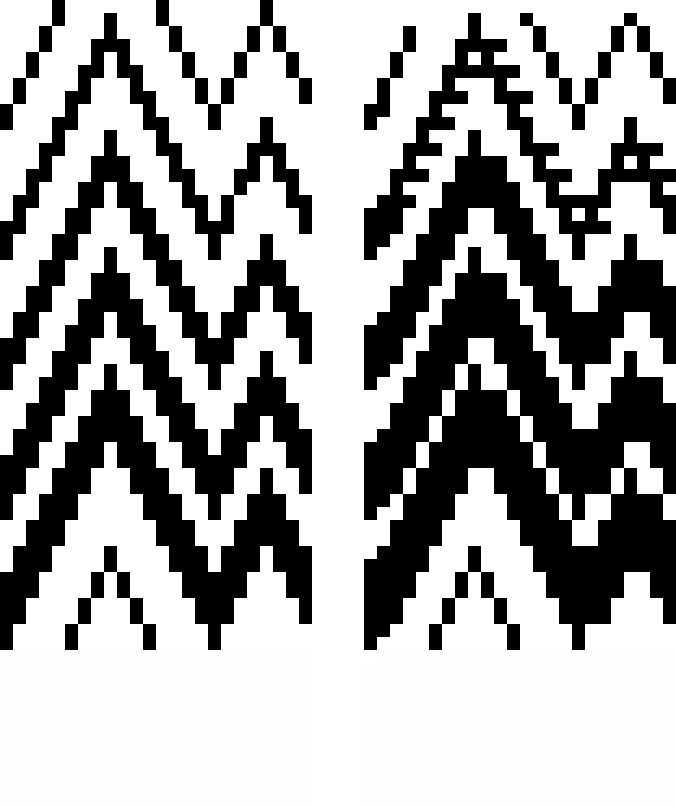

In [106]:
pattern = pad_c[None,np.random.randint(pad_c.shape[0]),:1488,:]

real = plot_pattern(np.squeeze(pattern))
fake = plot_pattern(np.squeeze(model.predict(pattern)))

new_im = Image.new('L', (real.width*2 + 52, real.height), color=255)

offset = 52 + real.width
new_im.paste(real, (0,0))
new_im.paste(fake, (offset,0))
display(new_im)

In [108]:
np.squeeze(model.predict(pattern))[-1]

array([  2.48319993e-05,   2.96953076e-05,   9.99945521e-01], dtype=float32)

In [55]:
pad_c[None,2,:1488,:].shape

(1, 1488, 3)